In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [61]:
# by default np.load() loads the data as a namespace, wrapping it in dict()
# loads all the data into a (more familiar) dictionary format
bundle = dict(np.load("frame_bundle.npz", allow_pickle=True))

In [62]:
 # .npz files save all elements as numpy arrays
# .item() removes the array wrapping
def de_item(bundle):
    """ Call .item() on all dictionary items
        removes unnecessary extra dimension
    """

    bundle['motion'] = bundle['motion'].item()
    bundle['characteristics'] = bundle['characteristics'].item()
        
    for i in range(bundle['num_raw_frames']):
        bundle[f'raw_{i}'] = bundle[f'raw_{i}'].item()

de_item(bundle)

This bundle data contains three sets of data:
1. `motion`: gyro/accelerometer measurements
2. `characteristics`: Physical camera properties
3. `raw_[x]`: Bayer RAW frames with metadata enumerated from `0` to `num_raw_frames - 1`


In [63]:
bundle["motion"].keys()

dict_keys(['timestamp', 'quaternion', 'acceleration'])

We see that `motion` contains device rotations in `quaternion` format (wxyz) as well as `acceleration` (xyz) recorded at `timestamp` times (seconds).

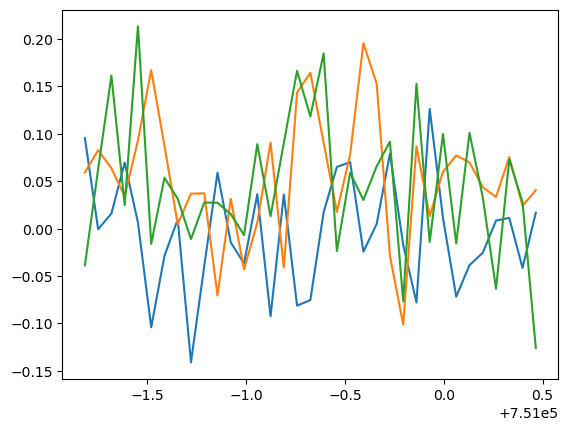

In [64]:
acceleration =  bundle["motion"]["acceleration"] # [3,N]
timestamp =  bundle["motion"]["timestamp"] # [N]

plt.plot(timestamp, acceleration)
plt.show()

Next, `characteristics` contains a range of information about the camera used for capturing the data, including the arrangement of its bayer filters, its aperture, focal length, and minumum focal distance.

In [65]:
bundle['characteristics'].keys()

dict_keys(['android', 'color_filter_arrangement', 'pose_reference', 'pose_rotation', 'pose_translation', 'aperture', 'focal_length', 'minimum_focus_distance', 'hyperfocal_distance'])

In [66]:
bundle['characteristics']['aperture']

1.85

In [67]:
bundle['characteristics']['color_filter_arrangement']
# 0: RGGB, 1: GRBG, 2: GBRG, 3: BGGR, see: 
# https://developer.android.com/reference/android/hardware/camera2/CameraCharacteristics

2

`android` is a catch-all for all other metadata that `convert_files` did not parse from binary string format:

In [68]:
bundle['characteristics']['android']

{'control.aeAvailableTargetFpsRanges': '[15, 15], [15, 30], [30, 30], [15, 60], [60, 60]',
 'control.aeLockAvailable': True,
 'control.awbLockAvailable': True,
 'control.maxRegionsAe': 1,
 'control.maxRegionsAf': 1,
 'control.maxRegionsAwb': 0,
 'depth.depthIsExclusive': False,
 'flash.info.available': True,
 'flash.info.strengthDefaultLevel': 45,
 'flash.info.strengthMaximumLevel': 45,
 'info.supportedHardwareLevel': 1,
 'jpeg.availableThumbnailSizes': '0x0, 176x144, 240x144, 256x144, 240x160, 256x154, 246x184, 240x240, 320x240, 408x308',
 'lens.distortion': '0.08679182, -0.113809735, 0.053207975, 0.0, 0.0',
 'lens.facing': 1,
 'lens.info.availableApertures': 1.85,
 'lens.info.availableFilterDensities': 0.0,
 'lens.info.availableFocalLengths': 6.81,
 'lens.info.focusDistanceCalibration': 1,
 'lens.info.hyperfocalDistance': 0.1915709,
 'lens.info.minimumFocusDistance': 9.523809,
 'lens.intrinsicCalibration': '2775.4246, 2775.4246, 2019.7947, 1542.3264, 0.0',
 'lens.poseReference': 0,
 

Lastly the `raw_[x]` entries contain our actual recorded image data:

In [69]:
frame = 0 # change this to view other frames
raw = bundle[f"raw_{frame}"]
print(raw.keys())

dict_keys(['android', 'frame_count', 'timestamp', 'ISO', 'exposure_time', 'aperture', 'blacklevel', 'whitelevel', 'focal_length', 'focus_distance', 'intrinsics', 'shade_map', 'lens_distortion', 'raw', 'height', 'width'])


Just like `characteristics`, this raw contains a range of useful metadata such as ISO, exposure time, whitelevel, color correction terms, and camera intrinsics

In [70]:
print("ISO", raw["ISO"], ",", "Exposure Time", raw['exposure_time'])
print("Intrinsics:")
print(raw['intrinsics'])

ISO 47 , Exposure Time 0.000848064
Intrinsics:
[[2.8814590e+03 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 2.8814590e+03 0.0000000e+00]
 [2.0294973e+03 1.5652214e+03 1.0000000e+00]]


Last, but not least, is the actual RAW image data. A single layer mosaiced `uint16` array.

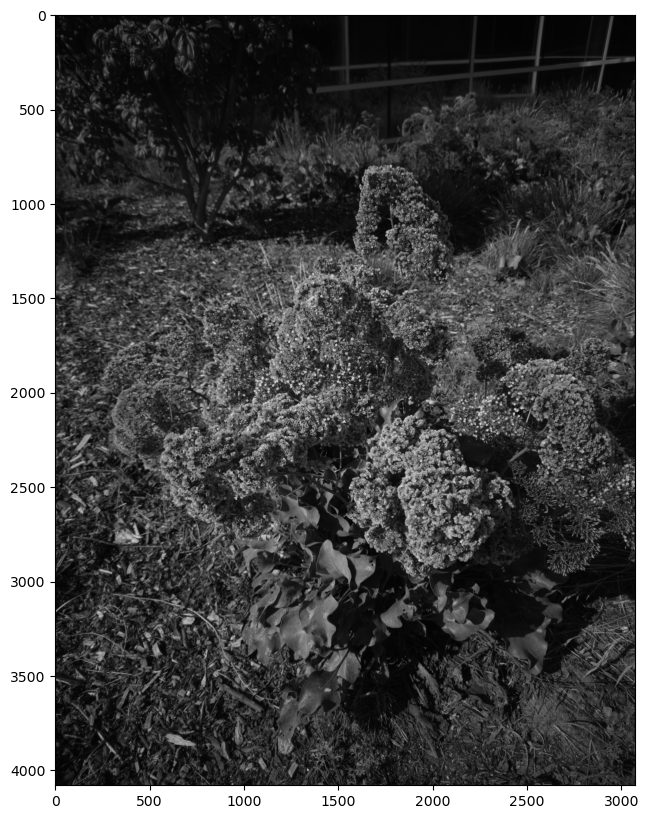

In [71]:
raw_img = raw["raw"]
plt.figure(figsize=(10, 10))
# rotate back to portrait
plt.imshow(np.log1p(np.rot90(raw_img, 3)), cmap="gray")